In [1]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

import matplotlib as mpl
mpl.rcParams['font.size']=16
mpl.rcParams['font.serif'] = "Bitstream Vera Serif"
mpl.rcParams['font.family'] = "serif"
import glob
import sys
sys.path.append('/reg/neh/home/qiaoshen/GitHub/loki/src/RingData/')
from DiffCorr import DiffCorr

from matplotlib.gridspec import GridSpec

In [2]:
def normalize(d, zero=True):
    x=d.copy()
    if zero:
        x-=x.min()
    return x/(x.max()-x.min())

def reshape_unmasked_values_to_shots(shots,mask):
    # this takes vectors of unmasked values, and reshaped this into their masked forms
    # mask is 2D, shots are 1D
    assert(shots.shape[-1]==np.sum(mask) )
    flat_mask = mask.flatten()
    reshaped_shots = np.zeros( (shots.shape[0],mask.size), dtype=shots.dtype)
    
    reshaped_shots[:, flat_mask==1] = shots
    
    return reshaped_shots.reshape((shots.shape[0],mask.shape[0],mask.shape[1]))

def compute_asym(corr, phi_offset=10,num_phi=354, norm = True):
    if norm:
        asym = (normalize_set(corr[:,phi_offset:num_phi/2-phi_offset])\
                      -normalize_set(corr[:,num_phi/2+phi_offset:-phi_offset]) )
    else:
        asym=(corr[:,phi_offset:num_phi/2-phi_offset]\
                      -corr[:,num_phi/2+phi_offset:-phi_offset])\
        /(corr[:,phi_offset:num_phi/2-phi_offset].max()\
          -corr[:,num_phi/2+phi_offset:-phi_offset].min())
        
    return np.mean(asym**2, axis=-1)**0.5

def normalize_set(d):
    x=d.copy()
    x-=x.min(-1)[:,None]
    return x/(x.max(-1)[:,None])

In [3]:
qvalue=np.load('/reg/neh/home/qiaoshen/notebooks/OE_figures/qvalues.npy')
print qvalue[19]

0.58695298347


In [7]:
f = h5py.File('/reg/d/psdm/cxi/cxilp6715/scratch/denoise_polar_intensity/diagnostics/all_pca_maskByRun/GDP_pro/run31_PCA-denoise.h5','r')
var_ratio = f['q%d'%qidx]['explained_variance_ratio'].value

In [4]:
f_mask = h5py.File('/reg/d/psdm/cxi/cxilp6715/scratch/combined_tables/finer_q/run31.tbl','r')

mask = f_mask['polar_mask_binned'].value
mask = (mask==mask.max())
mask.shape
qs = np.linspace(0,1,mask.shape[0])
dc=DiffCorr(mask[None,:,:],qs,0,pre_dif=True)
mask_cor = dc.autocorr().mean(0)

f_mask.close()


In [5]:
phi_offset=30
num_phi = 354
exp_cpsi=np.load('/reg/neh/home/qiaoshen/notebooks/OE_figures/exp_cpsi.npy')[:,phi_offset:num_phi/2-phi_offset]
exp_cpsi.shape

(35, 117)

9


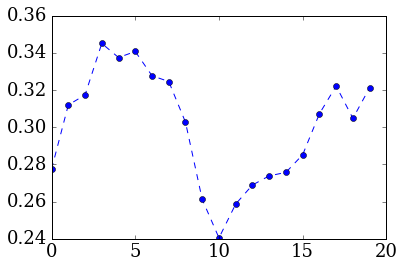

In [12]:
qidx=19
mpl.rcParams["font.size"]=18
nn=f['q%d'%qidx]['num_pca_cutoff'].value
comps=f['q%d'%qidx]['pca_components']
masked_comps=reshape_unmasked_values_to_shots(comps,mask[qidx][None,:])[:,0,:]
print nn

norm_cors  = []
cors=[]
for ii in range(20):
    
    y = (f['q%d'%qidx]['pca%d'%ii]['train_difcor'][0]/ mask_cor[qidx])[phi_offset:num_phi/2-phi_offset]
    y2 = f['q%d'%qidx]['pca%d'%ii]['train_difcor'][0]/ mask_cor[qidx]
    norm_cors.append(normalize(y) )
    cors.append(y2)
norm_cors=np.array(norm_cors)
cors=np.array(cors)

###comput asym
asym=compute_asym(cors, norm=True, phi_offset=30)
# plt.bar(range(asym.shape[0]),asym)
plt.plot(asym,'o--')


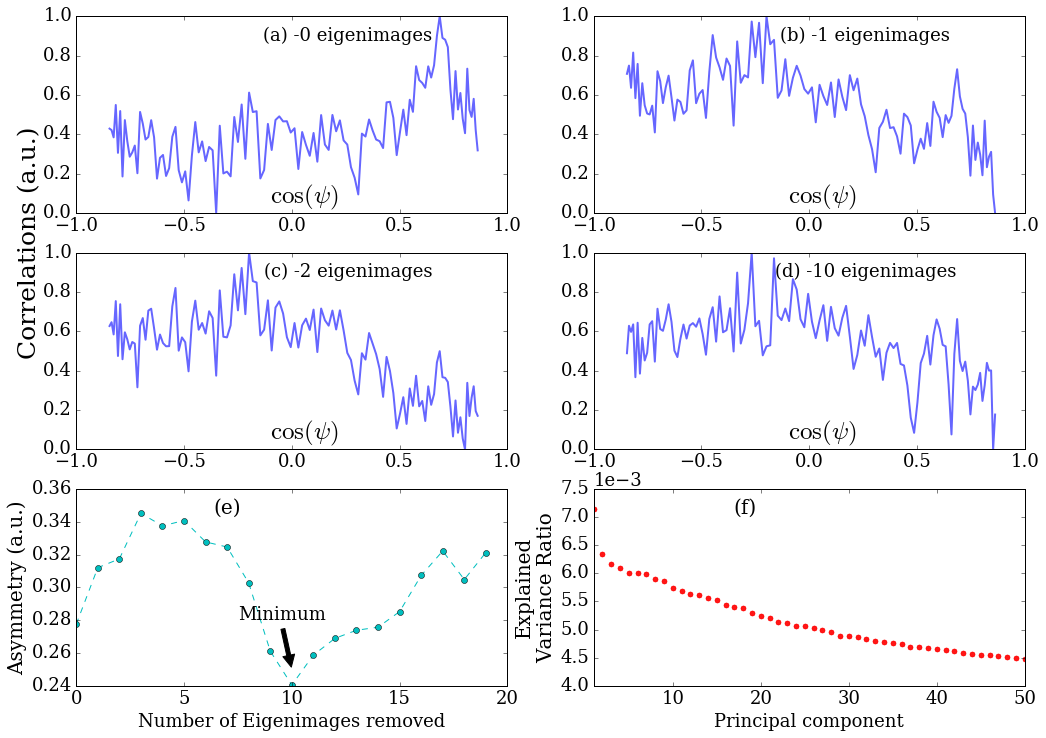

In [54]:

gs = GridSpec(3,2)
plt.figure(figsize=[17,12])
lables=['a','c','b','d']
for idx,ii in enumerate([0,2,1,10]):
    if idx<2:
        plt.subplot(gs[idx,0])
    else:
        plt.subplot(gs[idx-2,1])
    plt.plot(exp_cpsi[qidx],norm_cors[ii],'b', linewidth=2,alpha=0.6)
    plt.title('(%s) -%d eigenimages'%(lables[idx],ii),
              x=0.63,y=0.85, fontsize=18)
    
    plt.text(s='$\cos(\psi)$', x=-0.1,y=0.05,
             fontsize = 25)
    if idx==1:
        plt.text(s='Correlations (a.u.)', x=-1.27, y = 1.55,
                 fontsize = 25, rotation='vertical')
#######################################################################################################
num=3
letters=['d','e']
# fig=plt.figure(figsize=[8,12])
for ii in range(num):
   
    
    if ii==num-1:
        ax=plt.subplot(gs[2,0])
        plt.plot(asym,'co--')
        plt.title('(e)',x=0.35,y=0.85, fontsize=20)
        plt.xlabel('Number of Eigenimages removed')
        plt.ylabel('Asymmetry (a.u.)', fontsize = 20)
        
        ax.annotate('Minimum', xy=(10, 0.25), xytext=(7.5, 0.28),
            arrowprops=dict(facecolor='black', shrink=0.05),)
    else:
        
        plt.subplot(gs[2,1])
        
       
        plt.plot(range(1,51),var_ratio,'r.',
                 markersize=10,alpha=0.7, linewidth=2)
        plt.title('(f)',x=0.35,y=0.85, fontsize=20)
        plt.ylabel('Explained\nVariance Ratio', fontsize = 20)
        plt.xlabel('Principal component')
        plt.xlim(1,50)
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('run31_44690Shots_qidx19_PCAremove.png',bbox_inches='tight')